In [1]:
import torch
from procgen import ProcgenGym3Env
from torchinfo import summary
import core

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = None
player = None
ppo = None
env= None
envKW = {}

modelPath = "models/"
def loadAll(fname, loadEnv=True):
    model.load_state_dict(torch.load(modelPath + fname + "/model.pth"))
    player.load_state_dict(torch.load(modelPath + fname + "/player.pth"))
    ppo.load_state_dict(torch.load(modelPath + fname + "/ppo.pth"))
    if loadEnv:
        envKW = torch.load(modelPath + fname + "/envKW.pth")
        env = ProcgenGym3Env(**envKW)
        env.callmethod("set_state", torch.load(modelPath + fname + "/env_states.pth"))
    else:
        player.reset()

def saveAll(fname):
    import os
    os.makedirs(modelPath + fname, exist_ok=True)
    torch.save(model.state_dict(), modelPath + fname + "/model.pth")
    torch.save(player.state_dict(), modelPath + fname + "/player.pth")
    torch.save(ppo.state_dict(), modelPath + fname + "/ppo.pth")
    torch.save(envKW, modelPath + fname + "/envKW.pth")
    torch.save(env.callmethod("get_state"), modelPath + fname + "/env_states.pth")
    torch.save(ppo.all_stats, modelPath + fname + "/stats.pth")


cuda:0


In [2]:
num_agents = 64
epoch_steps = 256
envKW = core.getKW(num=num_agents, env_name="coinrun", distribution_mode="easy", paint_vel_info=True, use_backgrounds=False, restrict_themes=True)
env = ProcgenGym3Env(**envKW)
print(env.ob_space)
print(env.ac_space)

Dict(rgb=D256[64,64,3])
D15[]


In [3]:
from CVModels import CNNAgent, ViTValue, ImpalaValue
modelName = "Impala"
if modelName == "Impala":
    model = ImpalaValue().to(device)
elif modelName == "ViT60":
    model = ViTValue(depth=4, num_heads=4, embed_dim=32, mlp_ratio=4, valueHeadLayers=1).to(device)
elif modelName == "ViT15":
    model = ViTValue(depth=3, num_heads=4, embed_dim=16, mlp_ratio=4, valueHeadLayers=1).to(device)
elif modelName == "resnet":
    model = CNNAgent([64, 64, 3], 15, channels=16, layers=[1,1,1,1], scale=[1,1,1,1], vheadLayers=1).to(device)
model.train()
summary(model, input_size=(2, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
ImpalaValue                              [2, 15]                   --
├─ImpalaModel: 1-1                       [2, 256]                  --
│    └─ImpalaBlock: 2-1                  [2, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [2, 16, 64, 64]           448
│    │    └─ResidualBlock: 3-2           [2, 16, 32, 32]           4,640
│    │    └─ResidualBlock: 3-3           [2, 16, 32, 32]           4,640
│    └─ImpalaBlock: 2-2                  [2, 32, 16, 16]           --
│    │    └─Conv2d: 3-4                  [2, 32, 32, 32]           4,640
│    │    └─ResidualBlock: 3-5           [2, 32, 16, 16]           18,496
│    │    └─ResidualBlock: 3-6           [2, 32, 16, 16]           18,496
│    └─ImpalaBlock: 2-3                  [2, 32, 8, 8]             --
│    │    └─Conv2d: 3-7                  [2, 32, 16, 16]           9,248
│    │    └─ResidualBlock: 3-8           [2, 32, 8, 8]          

In [4]:
# model.load_state_dict(torch.load(modelPath + "vitNegT8BigFin" + "/model.pth"))

In [5]:
from PPO import PPO
import ProcgenPlayer

gamma = 0.99
# gamma = 0.999
rewardScale = 10
terminateReward = 1 - 10.0 / rewardScale

# livingReward = 0
livingReward = -1e-3
# lr = 1e-3
lr = 2.5e-4
# ent_coef = 0
ent_coef = 1e-2
print("terminateReward", terminateReward, "livingReward", livingReward, "discountedSumLiving", livingReward / (1 - gamma)) # if terminate reward > discountedSumLiving the agent will perfer to run into obstacles.
player = ProcgenPlayer.Player(env, num_agents=num_agents, 
                              epsilon=0, epsilon_decay=1, 
                              rewardScale=rewardScale, livingReward=livingReward, terminateReward=terminateReward, 
                              finishedOnly=True, maxStaleSteps=64)
ppo = PPO(model, env, num_agents=num_agents, player=player, 
          lr=lr, gamma=gamma, weight_decay=0.0, ent_coef=ent_coef, 
          warmup_steps=10, train_steps=1000, epoch_steps=epoch_steps, 
          batch_size=1, epochs_per_game=3)

terminateReward 0.0 livingReward -0.001 discountedSumLiving -0.09999999999999991


c:\ProgramData\Miniconda3\envs\torch\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [6]:
# ppo.runGame()
# loss = ppo.train(debug=True)
# print(loss)
# import torchviz
# torchviz.make_dot(loss, params=dict(model.named_parameters()))

In [7]:
# loadAll("vitBig50RS10G0.99LvFalse_4-5")
print(ppo.params)
print(player.params)
print(envKW)

{'alg_name': 'ppo', 'lr': 0.00025, 'gamma': 0.99, 'lam': 0.95, 'whiten': True, 'cliprange': 0.2, 'cliprange_value': 0.2, 'vf_coef': 0.5, 'epoch_steps': 256, 'epochs_per_game': 3, 'ent_coef': 0.01, 'weight_decay': 0.0, 'warmup_steps': 10, 'train_steps': 1000, 'batch_size': 1}
{'alg_name': 'ppo', 'epsilon': 0, 'epsilon_decay': 1, 'rewardScale': 10, 'livingReward': -0.001, 'terminateReward': 0.0, 'finishedOnly': True, 'maxStaleSteps': 64}
{'num': 64, 'env_name': 'coinrun', 'distribution_mode': 'easy', 'paint_vel_info': True, 'use_backgrounds': False, 'restrict_themes': True}


In [8]:
for i in range(300 // ppo.params['epochs_per_game']):
    ppo.runGame()
    ppo.train()
    if i % 10 == 0:
        # print("episodeLength", ppo.all_stats[-1]["game/episodeLength"], "episodeReward", ppo.all_stats[-1]["game/episodeReward"],
        #       "epoch", ppo.all_stats[-1]["epoch"], "steps", ppo.all_stats[-1]["steps"], 
        #       "\nloss", ppo.all_stats[-1]["ppo/loss/total"].item(), "policy", ppo.all_stats[-1]["ppo/loss/policy"].item(), 
        #       "value", ppo.all_stats[-1]["ppo/loss/value"].item(),
        #       "entropy", ppo.all_stats[-1]["ppo/policy/entropy"].item())
        print(f"episodeLength {ppo.all_stats[-1]['game/episodeLength']:.4f} episodeReward {ppo.all_stats[-1]['game/episodeReward']:.4f} " + 
              f"epoch {ppo.all_stats[-1]['epoch']} steps {ppo.all_stats[-1]['steps']} " +
              f"loss {ppo.all_stats[-1]['ppo/loss/total'].item():.4f} policy {ppo.all_stats[-1]['ppo/loss/policy'].item():.4f} " +
              f"value {ppo.all_stats[-1]['ppo/loss/value'].item():.4f} entropy {ppo.all_stats[-1]['ppo/policy/entropy'].item():.4f} " +
              f"stale {ppo.all_stats[-1]['game/staleSteps']}              ")
        # print(ppo.all_stats[-1])
    else:
        print(f"episodeLength {ppo.all_stats[-1]['game/episodeLength']:.4f} episodeReward {ppo.all_stats[-1]['game/episodeReward']:.4f} " + 
              f"epoch {ppo.all_stats[-1]['epoch']} steps {ppo.all_stats[-1]['steps']} " +
              f"loss {ppo.all_stats[-1]['ppo/loss/total'].item():.4f} policy {ppo.all_stats[-1]['ppo/loss/policy'].item():.4f} " +
              f"value {ppo.all_stats[-1]['ppo/loss/value'].item():.4f} entropy {ppo.all_stats[-1]['ppo/policy/entropy'].item():.4f} " +
              f"stale {ppo.all_stats[-1]['game/staleSteps']}              ", end="\r")
        
    if i % (50 // ppo.params['epochs_per_game']) == 0:
        saveAll(f"{modelName}{ppo.all_stats[-1]['epoch']}RS{rewardScale}G{gamma}Lv{livingReward!=0}_4-6")
    # if i % 100 == 0:
    #     stats = ppo.all_stats[-1]
    #     for k, v in stats.items():
    #         # if "time" in k:
    #         print(k, v)

episodeLength 206.8182 episodeReward -0.2068 epoch 2 steps 16384 loss -0.0311 policy -0.0043 value 0.0002 entropy 2.6977 stale 0              
episodeLength 582.6429 episodeReward -0.4041 epoch 32 steps 180224 loss -0.0332 policy -0.0069 value 0.0002 entropy 2.6522 stale 64              
episodeLength 118.8370 episodeReward 0.3997 epoch 62 steps 344064 loss -0.0439 policy -0.0191 value 0.0007 entropy 2.5453 stale 64               
episodeLength 81.9381 episodeReward 0.4232 epoch 92 steps 507904 loss -0.0408 policy -0.0175 value 0.0010 entropy 2.4264 stale 64               
episodeLength 56.2983 episodeReward 0.4522 epoch 122 steps 671744 loss -0.0416 policy -0.0198 value 0.0013 entropy 2.3108 stale 64              
episodeLength 65.0197 episodeReward 0.3720 epoch 152 steps 835584 loss -0.0454 policy -0.0232 value 0.0012 entropy 2.3416 stale 64              
episodeLength 63.7679 episodeReward 0.4130 epoch 182 steps 999424 loss -0.0396 policy -0.0177 value 0.0014 entropy 2.3287 stale 64

In [9]:
# saveAll("vitNegT8BigFinG999Lv400_4-5")

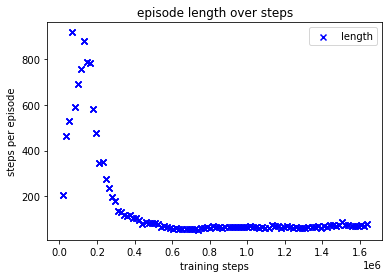

In [24]:
import matplotlib.pyplot as plt
# graph all episode lengths and episode rewards over steps
plt.scatter([s["steps"] for s in ppo.all_stats], [s["game/episodeLength"] for s in ppo.all_stats], label="length", color="blue", marker="x")
plt.xlabel("training steps")
plt.ylabel("steps per episode")
plt.legend()
plt.title("episode length over steps")
plt.show()

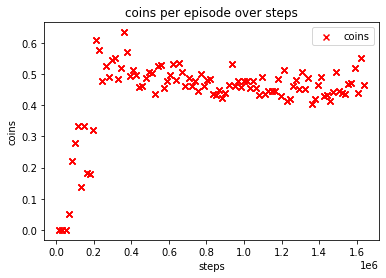

In [25]:
plt.scatter([s["steps"] for s in ppo.all_stats], [s["game/nonZeroReward"] for s in ppo.all_stats], label="coins", color="red", marker="x")
plt.xlabel("steps")
plt.ylabel("coins")
plt.legend()
plt.title("coins per episode over steps")
plt.show()

# per episode discounted cumulative reward. don't count steps. One point per episode, show every episode. Store data from every episode.

# check ppo paper for metrics.
# average reward per episode over entire training period favors fast learning
# average reward per episode over last 100 episodes of training favors final performance
# We scored each run of the algorithm by computing the average total reward of the last 100 episodes.

Experiment Notes

1. coin run hard

Higher reward per episode is better, and shorter episodes are better. Not sure if reward per timestep consolidates these.
The model can learn, and actively persue the reward but get lower reward because it now dies more. Though this is clearly better than headslamming a wall for several hundred  timesteps before randomly jumping into a coin. Shorter episodes also means higher sample size on reward per episode.

1.1 VIT 15k

LR 1e-3 warmup and cosine decay

Weight decay 0.01, living reward -0.001
Doesn't like to jump doesn't seem to avoid enemies.

Weight decay 0.01
Doesn't like to jump

No wd or livrew
Gets stuck going right

Removed Background and theme variation
got up to 87% rewards, though most epochs are ~70%
Very jumpy, spends almost no time on ground
Does not seem to avoid obstacles, always jump appears to be a passive strategy

Negative terminate reward. +1 for coin, -1 for enemy or timeout.
never got better than -1 reward.

Negative terminate reward. +1 for coin, -0.25 for enemy or timeout.
Improves for 200 epochs, gets worse around 350. Gets to around 0.5 which is 75% of coins.

1.2 VIT 60k
2 Layer value head degrades performance, is about 2k extra params. Vf loss gets larger when training.

Negative terminate reward. +1 for coin, -0.25 for enemy or timeout.
Did well until an over 1k step episode, spiked vf error.

Keep running environment on extra steps until every episode finishes.
Stale steps started very high around 90, but by epoch 70 it was down to 140. 256 steps per epoch, so a value higher than 256 is an entirely stale epoch.
Was considering capping the amount of stale steps, but it seems to work without this after a bit.
Reward is steadily increasing.
Still very jumpy but not as much as other models. Stays on ground for a few frames. Does not seem to actively avoid obstacles, though appears to be favoring landing on boxes over the ground which are always safe.
400 epochs, doesn't favor boxes as much, might be a bit better at jumping over gaps and avoiding obstacles.

Add living reward, train from previous model.
Discounted Sum of infinite living rewards is less than half the terminate reward so the agent should not perfer to hit an obstacle and end the episode.
Reduced high episode lenght faster by epoch 50
1000 step episodes at epoch 140 and derailed

For all above there was an issue with compute advantages where the first advantage of an episode would be set to zero. Probably had little impact.

3/31
Multiple tests with -0.001 living reward failed to learn. Vf loss went to 0, but episode length stayed at 1000 and reward at -1.25.
Removing living reward appears to work better at first and then back to failing. Not sure what changed since last living reward run.

Increase warmup to 40 epochs. At 50 epochs, reward was back to -0.25

Hyperparams from openai train-procgen
lr 5e-4, ent 0.01, gamma 0.999
Did better at first fell back to zero

1e-4 never gets above 0.

3 ppo epochs per game loop. Worked until epoch 242 and then all zeros.
-1e-4 living reward did not help, -0.25 term reward did not help.

maxStaleSteps 64, same
1 agent, same

squeeze in player potentially causing collapse to 0 reward 1k step episodes.

Running on new version without this squeeze does not get stuck, but also appears pretty random.

Running without ent bonus, with eps 0.01, gamma 0.999 living reward
gets better until around epoch 130 and then gets worse

squeeze values causes collapse to 0 reward 1k step episodes, 
without squeeze values the shapes of the advantages become agent x agent which is wrong
this probably mixed values across the batch and added a bunch of erronous loss terms, 1 x agent * agent x 1
Everything above had either one of these issues. Fixed below.

1 reward for coin, 0 otherwise
{'alg_name': 'ppo', 'lr': 0.00025, 'gamma': 0.99, 'lam': 0.95, 'whiten': True, 'cliprange': 0.2, 'cliprange_value': 0.2, 'vf_coef': 0.5, 'epoch_steps': 256, 'epochs_per_game': 3, 'ent_coef': 0.01, 'weight_decay': 0.0, 'warmup_steps': 10, 'train_steps': 1000, 'batch_size': 1}
{'alg_name': 'ppo', 'epsilon': 0, 'epsilon_decay': 1, 'rewardScale': 10, 'livingReward': 0, 'terminateReward': 0.0, 'finishedOnly': True, 'maxStaleSteps': 64}
{'num': 64, 'env_name': 'coinrun', 'distribution_mode': 'easy', 'paint_vel_info': True, 'use_backgrounds': False, 'restrict_themes': True}
gets better than initialization, but isn't that great

Impala from train-procgen 600k param CNN
{'alg_name': 'ppo', 'lr': 0.00025, 'gamma': 0.99, 'lam': 0.95, 'whiten': True, 'cliprange': 0.2, 'cliprange_value': 0.2, 'vf_coef': 0.5, 'epoch_steps': 256, 'epochs_per_game': 3, 'ent_coef': 0.01, 'weight_decay': 0.0, 'warmup_steps': 10, 'train_steps': 1000, 'batch_size': 1}
{'alg_name': 'ppo', 'epsilon': 0, 'epsilon_decay': 1, 'rewardScale': 10, 'livingReward': 0, 'terminateReward': 0.0, 'finishedOnly': True, 'maxStaleSteps': 64}
{'num': 64, 'env_name': 'coinrun', 'distribution_mode': 'easy', 'paint_vel_info': True, 'use_backgrounds': False, 'restrict_themes': True}
Gets stuck at 0 reward, and exactly 0 vf error.

Impalla with terminate reward and living reward
gets stuck at 0 reward.

Impalla with living reward 
Hangs out at the start for a bit, and then moves right to coin. Does not avoid obstacles.

vitWide no living reward
stuck at 1000.

vitdeep no living
stuck at 1000

impala no living
near stuck at 1000, but still some rewards

impala no eps
stuck at 0.4 rew after 2146304 steps

impala eps 0.01
0.4 rew at 1654784 steps, stuck at 1000 after 2473984 steps



